# FHR Surrogate Model

Filename: ```test_LF.ipynb```  
Author: Jasmin Lim  
Description: Use system surrogate to reconstruct a SAM load follows case  
Date Created: 05-05-2024  

In [1]:
import time
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Import the system surrogate with pump

To use the gFHR System Surrogate, import ```systemSurrogate``` from the ```systemSurrogate.py``` file.

In [2]:
# import the surrogate model
from systemSurrogate import systemSurrogate
S = systemSurrogate()

### Import and Interpolate Data

There are two available datasets to run the surrogate model:
1. ```../data/gFHR-LF.csv``` : Load Follows Case (100% full power -> 60% full power -> 100% full power)
2. ```../data/gFHR-LF-15.csv``` : Load Follows Profile Case (Random Power Level Changes between 55% and 100%)

Import the data:  
1. Import the state values from the SAM data using ```systemSurrogate.states```  
2. Import the input values from the SAM data using ```systemSurrogate.inputs```  

Interpolate the data to have a constant 5 second time step:  
1. Define the interpolated time-range using the input time vector: $t_{start} = t_{u,start}$ and $t_{end} = t_{u,end}$

Finally, organize data for surrogate model prediction initialization:  
1. $\mathbf{x}_k \in \mathbb{R}^{(2,42)}$ : surrogate requires ```systemSurrogate.time_delay```=2 time delays  
2. $\mathbf{u}_P \in \mathbb{R}^{(N,2)}$ : surrogate input for $N$ prediction steps

In [3]:
# import the data
filename = "../data/gFHR-LF.csv"
x = pd.read_csv(filename, sep=',', header=0, usecols=S.states)[S.states].to_numpy()
u = pd.read_csv(filename, sep=',', header=0, usecols=S.inputs)[S.inputs].to_numpy()

# interpolate data
t_start = u[0,0]
t_end = u[-1,0]
time_step = 5

ti = np.arange(t_start,t_end,5)
xi = np.zeros((ti.shape[0],len(S.states)))
ui = np.zeros((ti.shape[0],len(S.inputs)))

xi[:,0] = ti
ui[:,0] = ti
for i in range(1,xi.shape[1]):
    xi[:,i] = np.interp(ti, x[:,0], x[:,i])
for i in range(1,ui.shape[1]):
    ui[:,i] = np.interp(ti, u[:,0], u[:,i])

# requirements for surrogate model initialization
xk = np.copy(xi[:S.time_delay,:]) # time-delay system states at xk and x_(k-1)
uP = np.copy(ui[S.time_delay:,:]) # input

### Run the prediction

In [4]:
start = time.time()
pred = S.predict(xk, uP) 
end = time.time()
print(f"Run Time: {end-start} [s]")
print(f"Run Time: {(end-start)/((uP[-1,0]-uP[0,0])/3600)} [s] for 1 hour of reactor time")

Run Time: 2.3478150367736816 [s]
Run Time: 0.21351860887672738 [s] for 1 hour of reactor time


### Plot the results

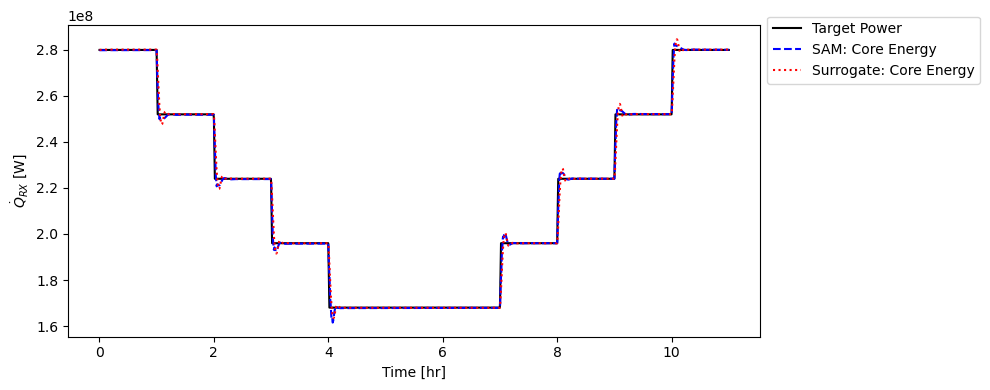

In [5]:
# plot target power and core energy
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(uP[:,0]/3600, uP[:,1], "-k", label="Target Power")
ax.plot(x[:,0]/3600, x[:,22], "--b", label="SAM: Core Energy")
ax.plot(pred[:,0]/3600, pred[:,22], ":r", label="Surrogate: Core Energy")
ax.set_ylabel(S.state_labels[22])
ax.set_xlabel(r"Time [hr]")
ax.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()

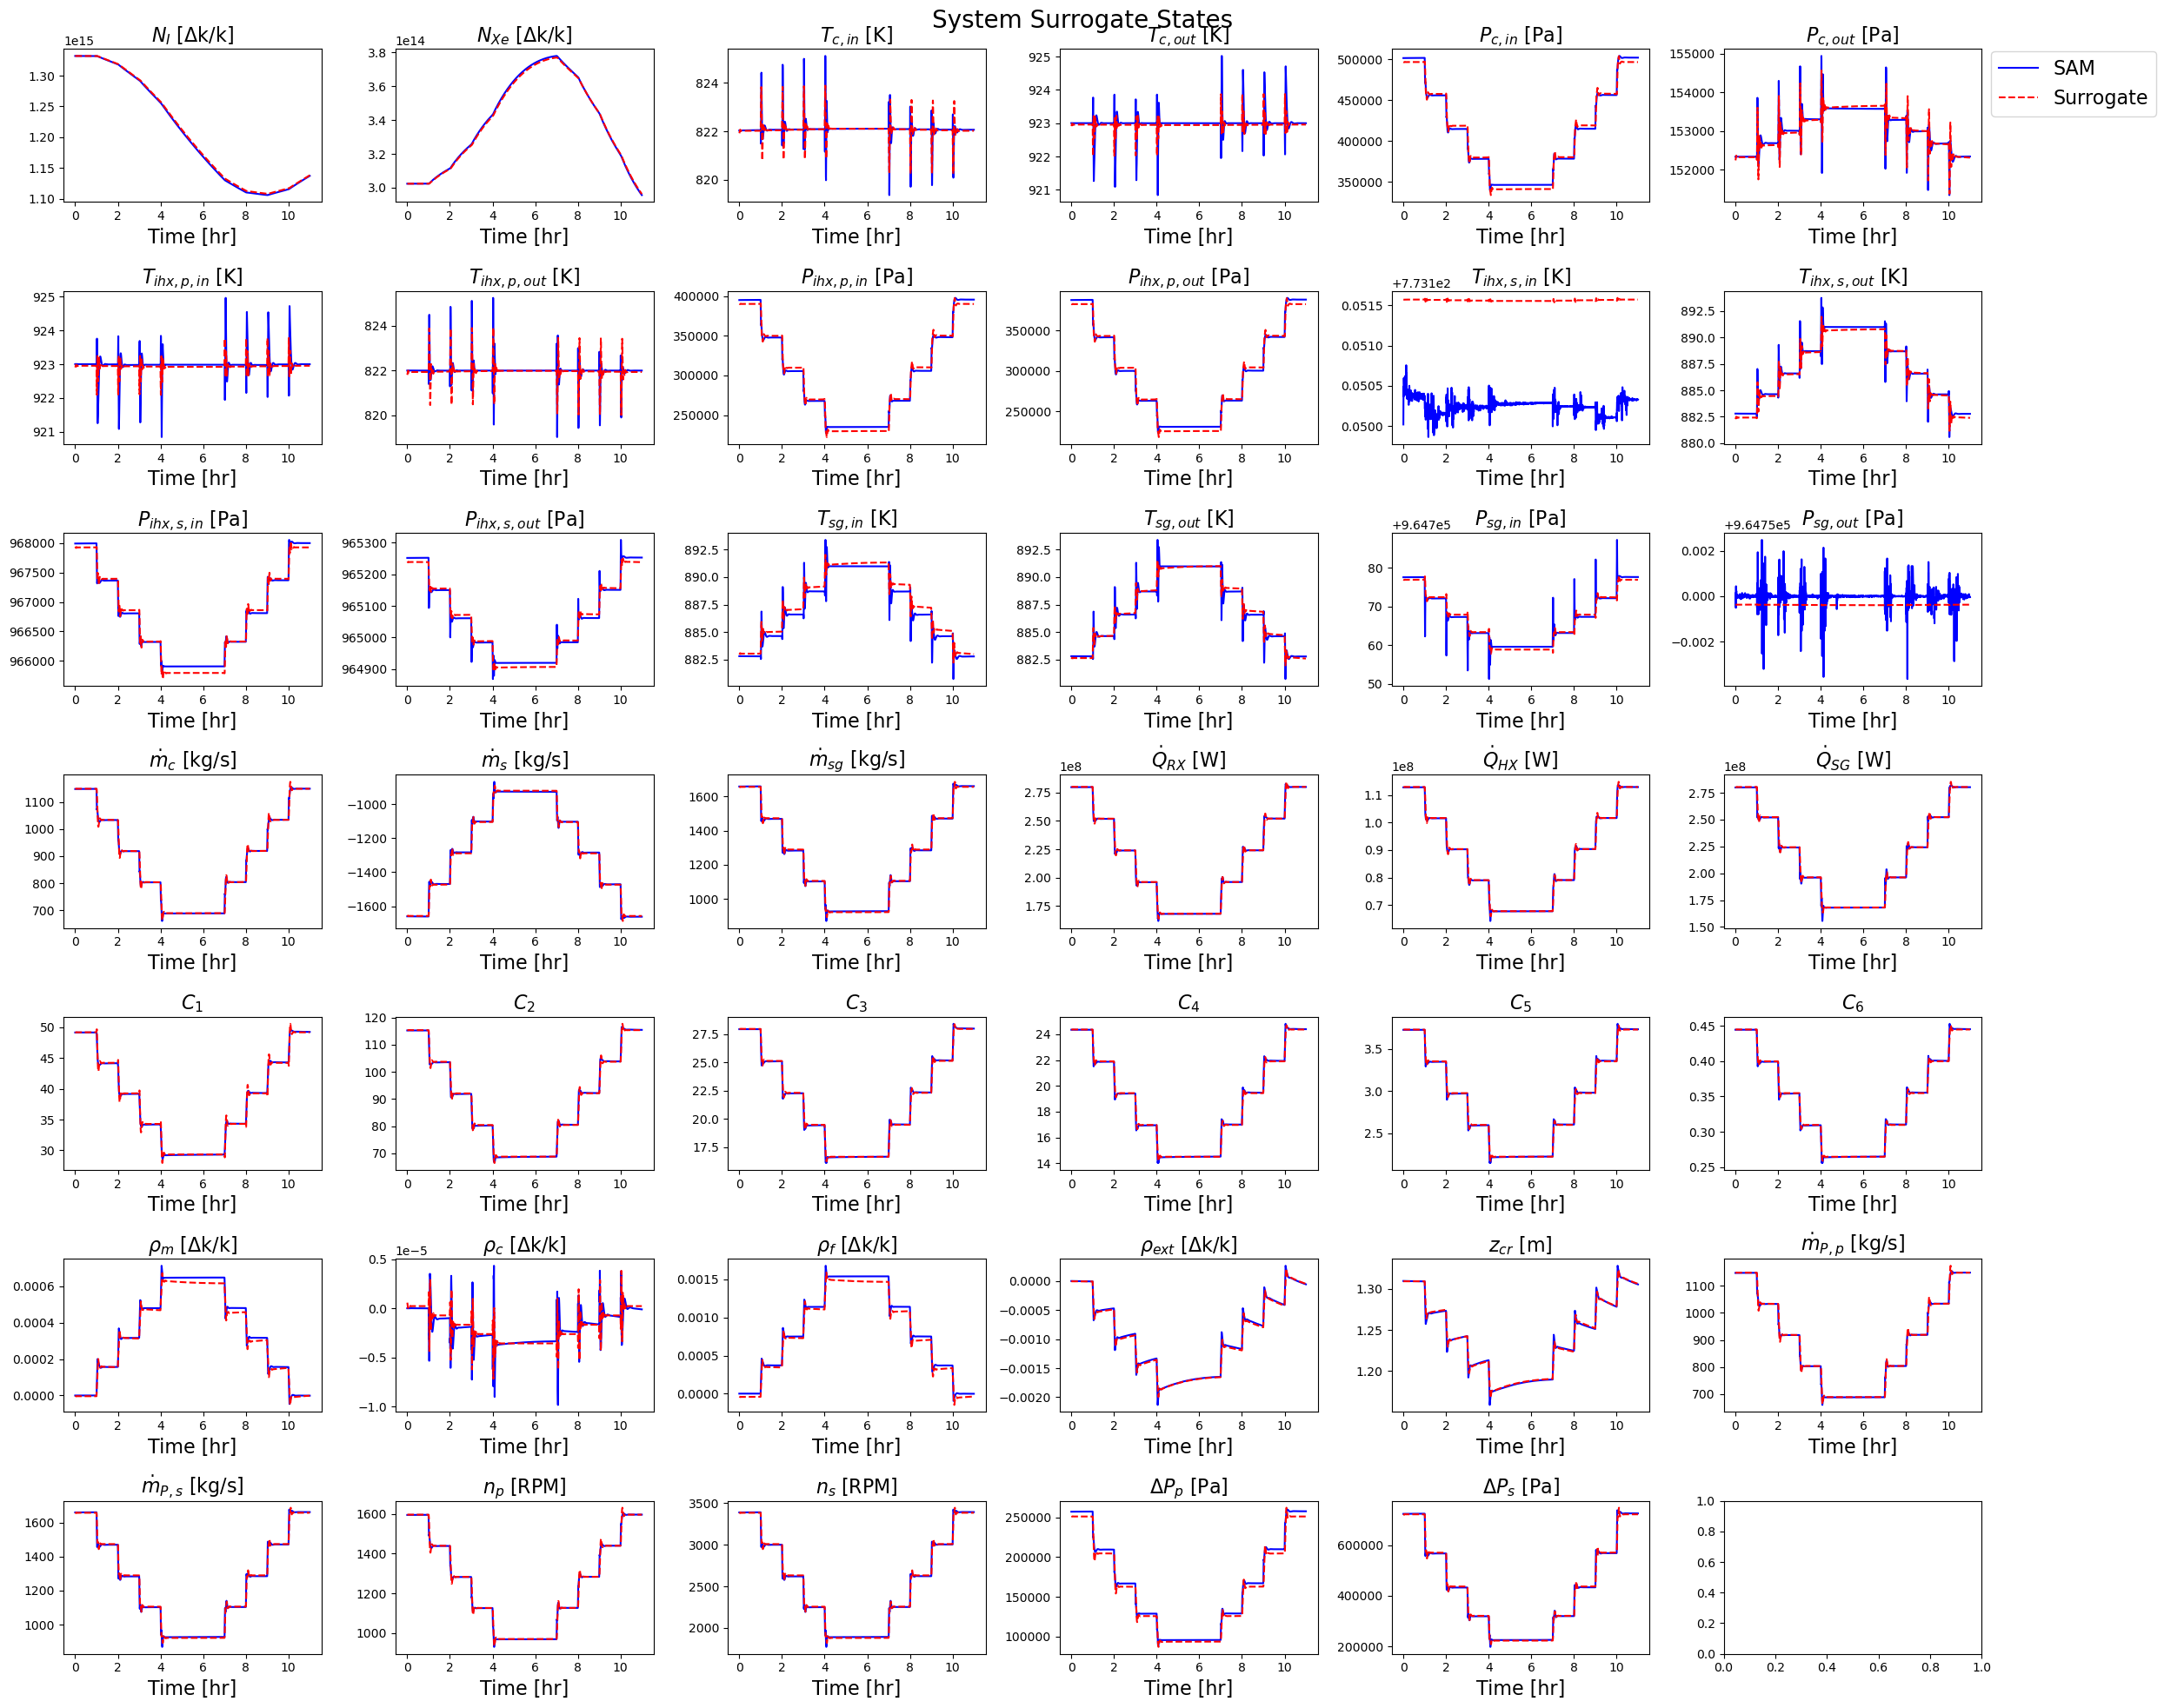

In [6]:
# plot full state results
split = (len(S.states)-1)//6
fig, ax = plt.subplots(7,split,figsize=(25,20))
for i in range(len(S.states)-1):
    ax[i//split,i%split].plot(x[:,0]/3600, x[:,i+1], "-b", label="SAM")
    ax[i//split,i%split].plot(pred[:,0]/3600, pred[:,i+1], "--r", label="Surrogate")
    ax[i//split,i%split].set_xlabel(r"Time [hr]", fontsize=16)
    ax[i//split,i%split].set_title(r"{}".format(S.state_labels[i+1]), fontsize=16)
ax[0,i%split+1].legend(bbox_to_anchor=(1., 1.05), fontsize=16)
plt.suptitle("System Surrogate States", fontsize=20)
plt.tight_layout()